In [ ]:
import numpy as np 
import pandas as pd
import tensorflow as tf
from nltk.corpus import stopwords           #for using stopwords
from nltk.stem.porter import PorterStemmer  # for stemming
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
import os
os.chdir('/content/drive/My Drive')
t=pd.read_csv('True.csv')
f=pd.read_csv('Fake.csv')

In [ ]:
t['category'] = 1
f['category'] = 0

df = pd.concat([t,f])

In [ ]:
#sort by date and apply a rolling window of classification
d2=df.sort_values(by='date')
d2['S_10'] = d2['category'].rolling(window=10).mean()


In [ ]:
#predict classification on average if >=0.5 then true else false
d2['p'] = np.where(d2['S_10']>0.5, 1, 0)
d2['match'] = np.where(d2['category']==d2['p'],1,0)


In [ ]:
#convert match to category
d2['m'] = np.where(d2['match']==1, 'Match', 'No Match')

(array([39414.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  5484.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

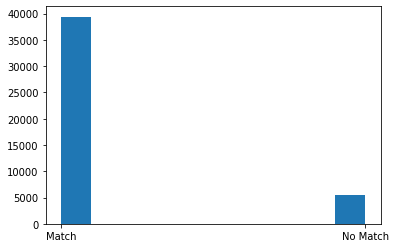

In [ ]:

import matplotlib.pyplot as plt
plt.hist(d2['m'])

In [ ]:
import regex as re

import nltk
from nltk.corpus import stopwords

cached_stopwords = stopwords.words('english')
porter = PorterStemmer()

In [ ]:

def replace_spec(text):
    regex = r'[^a-zA-z0-9/s]'
    text = re.sub(regex, ' ', text)
    return text

def process_title(title):
  
    title = title.lower()
    title = replace_spec(title)
    title=re.sub("donald trump","trump ",title)    
  
    title_list = str.split(title)
    
    final_title =[]

    for item in title_list:
        if item not in cached_stopwords:
            final_title.append(item)
    
    return " ".join(final_title)

In [ ]:
df['text_final'] = df.text.apply(process_title)

In [ ]:
import time
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
from nltk.tokenize import sent_tokenize, word_tokenize

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
def stemSentence(sentence):
    token_words=word_tokenize(sentence)
    
    stem_sentence=[]
    for word in token_words:
        stem_sentence.append(porter.stem(word))
        stem_sentence.append(" ")
    return "".join(stem_sentence)


In [ ]:
df['t'] = df.text_final.apply(stemSentence)


In [ ]:
# create term list
docs = df.t.tolist()

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
vectorizer = CountVectorizer()
cv = TfidfVectorizer(docs, use_idf=True)
count_vector=cv.fit_transform(docs)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import numpy as np
import math as math

In [ ]:
# create term frequency vector with IDF with min document frequency=3
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
vectorizer = TfidfVectorizer(strip_accents='unicode',min_df=3)

time_start = time.time()
vectorizer.fit(docs)
time_end = time.time()


print(f"vectorizer fit in {(time_end-time_start)/60} mins")

vectorizer fit in 0.13756959438323973 mins


In [ ]:
#split into 70 train and 30 test randomly
x_train, x_test, y_train, y_test = train_test_split(df[['t']], df['category'], test_size=.3, random_state=42)

In [ ]:
# get tfids using splits
train_tfidf = vectorizer.transform(x_train.t.tolist())
test_tfidf = vectorizer.transform(x_test.t.tolist())

In [ ]:
#36K vocab with less than 3 documents
train_tfidf.shape

(31428, 36631)

In [ ]:
#multinomial naive bayes model
mnb = MultinomialNB()


mnb.fit(train_tfidf, y_train.values)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [ ]:
# test mnb model on 70 30 split
for k, v in {'TRAIN': [train_tfidf, y_train], 'TEST': [test_tfidf, y_test]}.items():
    preds = mnb.predict(v[0])
    
    print(f"{k} RESULTS\n\n{classification_report(v[1],preds)}\n\n")
    #print(classification_report(y_test, y_pred,target_names=my_tags))

TRAIN RESULTS

              precision    recall  f1-score   support

           0       0.94      0.95      0.94     16485
           1       0.94      0.93      0.94     14943

    accuracy                           0.94     31428
   macro avg       0.94      0.94      0.94     31428
weighted avg       0.94      0.94      0.94     31428



TEST RESULTS

              precision    recall  f1-score   support

           0       0.93      0.94      0.94      6996
           1       0.93      0.93      0.93      6474

    accuracy                           0.93     13470
   macro avg       0.93      0.93      0.93     13470
weighted avg       0.93      0.93      0.93     13470





In [ ]:
#logistic regression 
from sklearn.linear_model import LogisticRegression

scikit_log_reg = LogisticRegression(verbose=1, solver='liblinear',random_state=0, C=5, penalty='l2',max_iter=1000)
model=scikit_log_reg.fit(train_tfidf, y_train.values)


[LibLinear]

In [ ]:
#select best features for logistic regression
from sklearn.feature_selection import SelectFromModel
m= SelectFromModel(model, prefit=True)
X_new = m.transform(train_tfidf)
X_2 = m.transform(test_tfidf)

In [ ]:
#size of new model -36K to 9k features
X_new.shape

(31428, 9080)

In [ ]:
#model run on all features
scikit_log_reg = LogisticRegression(verbose=1, solver='liblinear',random_state=0, C=5, penalty='l2',max_iter=1000)
model=scikit_log_reg.fit(train_tfidf, y_train.values)

[LibLinear]

In [ ]:
#model on selected features
m_cl=scikit_log_reg.fit(X_new, y_train.values)

[LibLinear]

In [ ]:
#find number of trees for random forest
x=[20,30,40,50]
from sklearn import metrics

In [ ]:
#run random forest with different number of features
from sklearn.ensemble import RandomForestClassifier
y=0
for i in range(len(x)):
     
     clf=RandomForestClassifier(n_estimators=x[i])
     clf.fit(train_tfidf, y_train.values)
     p=clf.predict(test_tfidf)
     x[y]=metrics.accuracy_score(y_test, p)
     y=y+1

In [ ]:
#create data frame with number of trees and accuracy
z=[20,30,40,50]
op = {'Trees': z, 'Accuracy': x}
op_2 = pd.DataFrame(op)


[Text(0, 0, '98.50%'),
 Text(0, 0, '98.60%'),
 Text(0, 0, '98.70%'),
 Text(0, 0, '98.80%'),
 Text(0, 0, '98.90%'),
 Text(0, 0, '99.00%'),
 Text(0, 0, '99.10%'),
 Text(0, 0, '99.20%'),
 Text(0, 0, '99.30%'),
 Text(0, 0, '99.40%')]

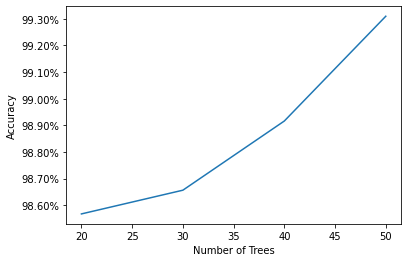

In [ ]:
#graph of accuracy vs trees
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
ax=plt.plot(z,x)
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.2f}%'.format(x*100) for x in plt.gca().get_yticks()]) 



In [ ]:
#random forest with 40 trees
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=40)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(train_tfidf, y_train.values)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=40,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
#10 fold validation with each model
p=cross_val_score(model,test_tfidf, y_test.values,cv=10)
p
n=cross_val_score(mnb,test_tfidf, y_test.values,cv=10)
n
r=cross_val_score(clf,test_tfidf, y_test.values,cv=10)
q=cross_val_score(m_cl,test_tfidf, y_test.values,cv=10)

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

In [ ]:
#count vector
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
vectorizer = CountVectorizer(strip_accents='unicode',min_df=3)

time_start = time.time()
vectorizer.fit(docs)
time_end = time.time()


print(f"vectorizer fit in {(time_end-time_start)/60} mins")

vectorizer fit in 0.13284128109614055 mins


In [ ]:
#get test and train sets with count vector
train_cnt = vectorizer.transform(x_train.t.tolist())
test_cnt = vectorizer.transform(x_test.t.tolist())

In [ ]:
#predictions for each model -logistic regression, naive bayes, random forest, and logistic regression clean data set
model=scikit_log_reg.fit(train_tfidf, y_train.values)
y_pred=model.predict(test_tfidf)
nb=mnb.predict(test_tfidf)

rf=clf.predict(test_tfidf)

l2=m_cl.predict(test_tfidf)

[LibLinear]

In [ ]:
# confusiin matrix for each model
from sklearn import metrics
cnf_matrix_nb = metrics.confusion_matrix(y_test.values, nb)
cnf_matrix_lr = metrics.confusion_matrix(y_test.values, y_pred)
cnf_matrix_rf = metrics.confusion_matrix(y_test.values, rf)
cnf_matrix_l2 = metrics.confusion_matrix(y_test.values, l2)

Text(0.5, 257.44, 'Predicted label')

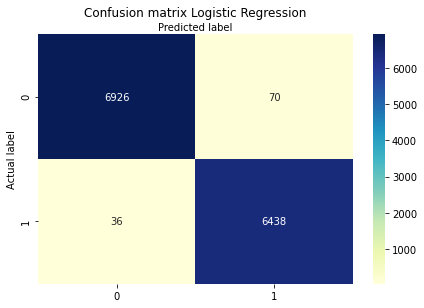

In [ ]:
#heatmap of logistic regression
import seaborn as sns
import matplotlib.pyplot as plt
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix_lr), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix Logistic Regression', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

Text(0.5, 257.44, 'Predicted label')

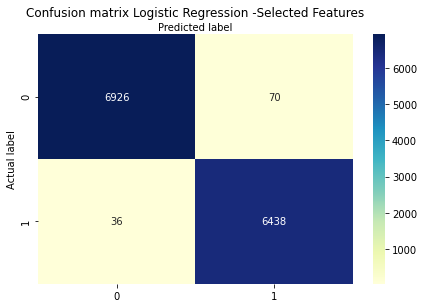

In [ ]:
#heatmap of logistic regression selected features
import seaborn as sns
import matplotlib.pyplot as plt
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix_l2), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix Logistic Regression -Selected Features', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

Text(0.5, 257.44, 'Predicted label')

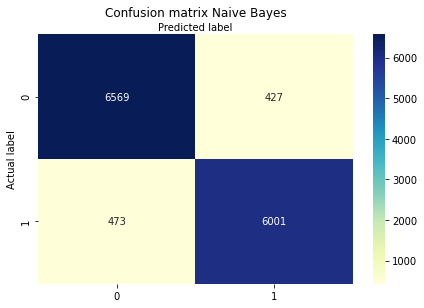

In [ ]:
#heatmap of nb
import seaborn as sns
import matplotlib.pyplot as plt
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix_nb), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix Naive Bayes', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

Text(0.5, 257.44, 'Predicted label')

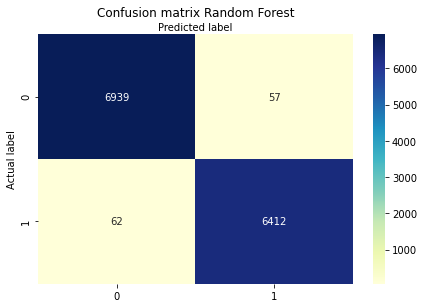

In [ ]:
#heatmap of random forest
import seaborn as sns
import matplotlib.pyplot as plt
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix_rf), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix Random Forest', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [ ]:
#metrics of nb
print("Accuracy: {:.2f}%".format(metrics.accuracy_score(y_test, nb)*100))
print("Precision: {:.2f}%".format(metrics.precision_score(y_test, nb)*100))
print("Recall: {:.2f}%".format(metrics.recall_score(y_test, nb)*100))
print("F Score: {:.2f}%".format(metrics.f1_score(y_test, nb)*100))

Accuracy: 93.32%
Precision: 93.36%
Recall: 92.69%
F Score: 93.02%


In [ ]:
#metrics of logistic regression
print("Accuracy: {:.2f}%".format(metrics.accuracy_score(y_test, y_pred)*100))
print("Precision: {:.2f}%".format(metrics.precision_score(y_test, y_pred)*100))
print("Recall: {:.2f}%".format(metrics.recall_score(y_test, y_pred)*100))
print("F Score: {:.2f}%".format(metrics.f1_score(y_test, y_pred)*100))

Accuracy: 99.21%
Precision: 98.92%
Recall: 99.44%
F Score: 99.18%


In [ ]:
#metrics of random forest
print("Accuracy: {:.2f}%".format(metrics.accuracy_score(y_test, rf)*100))
print("Precision: {:.2f}%".format(metrics.precision_score(y_test, rf)*100))
print("Recall: {:.2f}%".format(metrics.recall_score(y_test, rf)*100))
print("F Score: {:.2f}%".format(metrics.f1_score(y_test, rf)*100))


Accuracy: 99.12%
Precision: 99.12%
Recall: 99.04%
F Score: 99.08%


In [ ]:
#logistic regression selected features
print("Accuracy: {:.2f}%".format(metrics.accuracy_score(y_test, l2)*100))
print("Precision: {:.2f}%".format(metrics.precision_score(y_test, l2)*100))
print("Recall: {:.2f}%".format(metrics.recall_score(y_test, l2)*100))
print("F Score: {:.2f}%".format(metrics.f1_score(y_test, l2)*100))

Accuracy: 99.21%
Precision: 98.92%
Recall: 99.44%
F Score: 99.18%


In [ ]:
#data frame with 10 fold results of each model
lr = {'text': "LR", 'Category': p}
nb={'text': "NB", 'Category': n}
rf={'text': "RF", 'Category': r}

lr_test = pd.DataFrame(lr)
nb_test = pd.DataFrame(nb)
rf_test = pd.DataFrame(rf)

d2=pd.concat([lr_test,nb_test,rf_test])

In [ ]:
d2

,text,Category
0,LR,0.983667
1,LR,0.981440
2,LR,0.986637
3,LR,0.990349
4,LR,0.983667
5,LR,0.982925
6,LR,0.984410
7,LR,0.982925
8,LR,0.990349
9,LR,0.989607


In [ ]:
#kruskal walls test to determine difference of each test on tf vector
from scipy.stats import mstats


pval = mstats.kruskalwallis(nb['Category'],rf['Category'],lr['Category'])
pval


KruskalResult(statistic=19.415956259763433, pvalue=6.079651255793687e-05)

In [ ]:
d2.to_csv('tfidf1.csv')


In [ ]:
model=scikit_log_reg.fit(train_cnt, y_train.values)
mnb.fit(train_cnt, y_train.values)
clf.fit(train_cnt, y_train.values)

[LibLinear]

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=40,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
p=cross_val_score(model,test_cnt, y_test.values,cv=10)
p
n=cross_val_score(mnb,test_cnt, y_test.values,cv=10)
n
r=cross_val_score(clf,test_cnt, y_test.values,cv=10)

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

In [ ]:
lr = {'text': "LR", 'Category': p}
nb={'text': "NB", 'Category': n}
rf={'text': "RF", 'Category': r}

lr_test = pd.DataFrame(lr)
nb_test = pd.DataFrame(nb)
rf_test = pd.DataFrame(rf)

d2=pd.concat([lr_test,nb_test,rf_test])

In [ ]:
from scipy.stats import mstats


pval = mstats.kruskalwallis(nb['Category'],rf['Category'],lr['Category'])
pval

KruskalResult(statistic=25.91020772838955, pvalue=2.364121971895926e-06)

In [ ]:
d2

,text,Category
0,LR,0.991834
1,LR,0.994803
2,LR,0.989607
3,LR,0.993318
4,LR,0.992576
5,LR,0.992576
6,LR,0.994803
7,LR,0.992576
8,LR,0.992576
9,LR,0.995546


# New Section

In [ ]:
import scipy.stats as stats

s=stats.f_oneway(nb['Category'],rf['Category'],lr['Category'])
s

F_onewayResult(statistic=405.2308048818191, pvalue=7.301037240993819e-21)

In [ ]:
#ttest for each pair
from statsmodels.stats.multicomp import pairwise_tukeyhsd
posthoc = pairwise_tukeyhsd(
    d2['Category'], d2['text'],
    alpha=0.05)

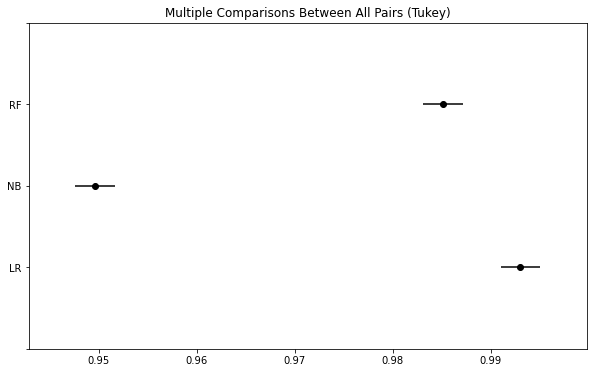

In [ ]:
fig = posthoc.plot_simultaneous()